## 1. **Business Understanding**

### Overview

SentimentFlow aims to address a real-world problem related to understanding public sentiment towards Apple and Google products on Twitter. The stakeholders include companies, marketing teams, and decision-makers who want to gauge public opinion and make informed strategic decisions based on social media sentiment.

### Problem Statement

The problem is to accurately classify the sentiment of tweets related to Apple and Google products. We want to determine whether a tweet expresses a positive, negative, or neutral sentiment. This classification can help companies understand customer satisfaction, identify potential issues, and tailor their responses accordingly.

### Objectives

Main Objective

> To develop a NLP (Natural Language Processing) multiclass classification model for sentiment analysis, aim to achieve a recall score of 80% and an accuracy of 80%. The model should categorize sentiments into three classes: Positive, Negative, and Neutral.

Specific Objectives

* To idenitfy the most common words used in the dataset using Word cloud.

* To confirm the most common words that are positively and negatively tagged.

* To recognize the products that have been opined by the users.

* To spot the distribution of the sentiments.

## 2. **Data Understanding**

### Data Sources
The dataset originates from CrowdFlower via data.world. Contributors evaluated tweets related to various brands and products. Specifically:
- Each tweet was labeled as expressing positive, negative, or no emotion toward a brand or product.
- If emotion was expressed, contributors specified which brand or product was the target.

### Suitability of Data
Here's why this dataset is suitable for our project:
1. **Relevance:** The data directly aligns with our business problem of understanding Twitter sentiment for Apple and Google products.
2. **Real-World Context:** The tweets represent actual user opinions, making the problem relevant in practice.
3. **Multiclass Labels:** We can build both binary (positive/negative) and multiclass (positive/negative/neutral) classifiers using this data.

### Dataset Size
The dataset contains over 9,000 labeled tweets. We'll explore its features to gain insights.

### Descriptive Statistics
- **tweet_text:** The content of each tweet.
- **is_there_an_emotion_directed_at_a_brand_or_product:** No emotion toward brand or product, Positive emotion, Negative emotion, I can't tell
- **emotion_in_tweet_is_directed_at:** The brand or product mentioned in the tweet.

### Feature Inclusion
Tweet text is the primary feature. The emotion label and target brand/product are essential for classification.

### Limitations
- **Label Noise:** Human raters' subjectivity may introduce noise.
- **Imbalanced Classes:** We'll address class imbalance during modeling.
- **Contextual Challenges:** Tweets are often short and context-dependent.
- **Incomplete & Missing Data:** Could affect the overall performance of the models.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


Load and Inspect data

In [3]:
# from typing_extensions import dataclass_transform
class DataUnderstanding:
  """Class for understanding the characteristics of the dataset"""
  def __init__(self, data= None):
    """Initialize the class with a DataFrame"""
    self.df= data

  def load_data(self, path):
    """Load data from a CSV file"""
    if self.df is None:
      self.df = pd.read_csv(path, encoding= 'latin-1')
    return self.df

  def preview_df(self):
    """Preview the DataFrame"""
    print("\n\nHEAD")
    print("-"*22)
    print(self.df.head())

  def display_info(self):
    """Display information about the DataFrame"""
    print("\n\nINFO")
    print("-"*22)
    print(self.df.info())

  def display_shape(self):
    """Display the shape of the DataFrame"""
    print("\n\nSHAPE")
    print("-"*22)
    print(f"Records: {self.df.shape[0]}, Features: {self.df.shape[1]}")

  def display_columns(self):
    """Display the columns in the dataset."""
    print("\nCOLUMNS")
    print("-" *22)
    for col in self.df.columns:
      print(f"- {col}")


  def display_missing_values(self):
    """Display missing values in each column"""
    print("\n\nMISSING VALUES")
    print("-"*22)
    for col in self.df.columns:
      print(f"{col}: {self.df[col].isnull().sum()}")

  def display_duplicates(self):
    """Display duplicate records in the DataFrame"""
    print("\n\nDUPLICATES")
    print("-"*22)
    print(f"Duplicate records: {self.df.duplicated().sum()}")

  def understand_data(self):
    """Display dataset overview"""
    self.preview_df()
    self.display_info()
    self.display_shape()
    self.display_columns()
    self.display_missing_values()
    self.display_duplicates()




In [4]:
# Load Data
data_und = DataUnderstanding()

df = data_und.load_data('/content/drive/MyDrive/phase_4_project/sentiment-analysis/judge-1377884607_tweet_product_company.csv')

data_und.understand_data()



HEAD
----------------------
                                          tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  


INFO
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

In essence, the dataset is designed to analyze sentiment, whether positive or negative, from tweets involving different products or brands.

The majority of these tweets - 5802 - don't specify any product or brand for which some decisions may be required in pre-processing.

The dataset is fairly clean; there are a few missing values in the 'tweet_text' and 'emotion_in_tweet_is_directed_at' columns and few duplicates.

Data Cleaning

In [5]:
#renaming columns for easier reference
df.rename (columns= {
    'tweet_text': 'tweets',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
}, inplace=True)

Handling duplicates

In [6]:
df.drop_duplicates(subset= 'tweets', inplace= True)

Handling missing values

In [7]:
# Drop the 1 in tweets column
df = df.dropna(subset=['tweets'])

In [8]:
# imputing missing values in product column with data from tweets

product_list = df['product'].unique()
product_list = [product for product in product_list if str(product) != 'nan']

def extract_product(tweet):
    for product in product_list:
        if product.lower() in tweet.lower():
            return product
    return None

df.loc[:, 'product']  = df.apply(lambda x: extract_product(x['tweets']) if pd.isna(x['product']) else x['product'], axis=1,)

df.head(5)

,tweets,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
df['product'].isnull().sum()

759

In [10]:
# drop the remaining
df = df.dropna(subset=['product'])

In [11]:
#check distribution of emotions
df['emotion'].value_counts()

,count
emotion,
No emotion toward brand or product,4633
Positive emotion,2955
Negative emotion,568
I can't tell,150


In [12]:
#drop records where emotion is i can't tell
df = df.drop(df[df['emotion'] == "I can't tell"].index)

In [13]:
# label emotion as 'positive', 'negative' and 'neutral'
df.loc[:, 'sentiment'] = df['emotion'].apply(lambda x: 'positive' if x == 'Positive emotion' else ('negative' if x == 'Negative emotion' else 'neutral'))
df.head()

,tweets,product,emotion,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,positive


In [14]:
#Ensure cleaning process worked effectively
data_und = DataUnderstanding(df)

data_und.understand_data()



HEAD
----------------------
                                              tweets             product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            emotion sentiment  
0  Negative emotion  negative  
1  Positive emotion  positive  
2  Positive emotion  positive  
3  Negative emotion  negative  
4  Positive emotion  positive  


INFO
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 8156 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweets     8156 non-null   object
 1   product    8156 non-null   object
 2   emotion    8156 non-null   ob

**Exploratory Data Analysis**

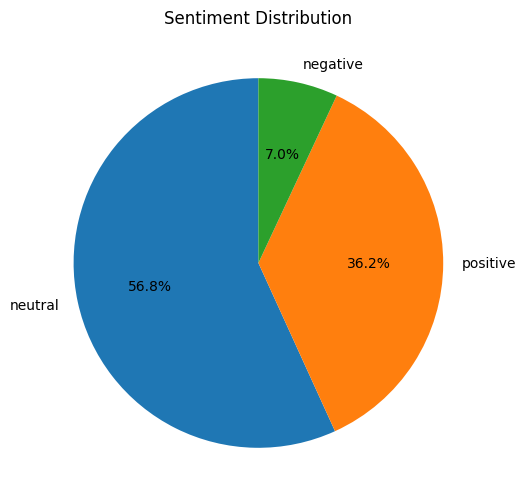

In [15]:
#sentiment distribution
sentiment_counts = df['sentiment'].value_counts()

# piechart
plt.figure(figsize=(8, 6))
labels= sentiment_counts.index
plt.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.show()


Class Imbalance is evident, seeing as more than 50% of the tweets convey neutral emotion and approximately 7% convey negative emotion.

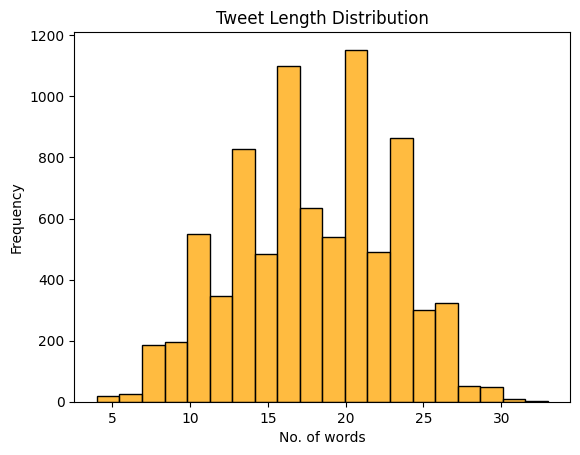

In [16]:
# tweet length distribution
df['tweet_length'] = df['tweets'].apply(lambda x: len(x.split()))

sns.histplot(df['tweet_length'], bins=20, color= 'orange')
plt.title('Tweet Length Distribution')
plt.xlabel('No. of words')
plt.ylabel('Frequency')
plt.show()


The tweets range between 4 and 33 words

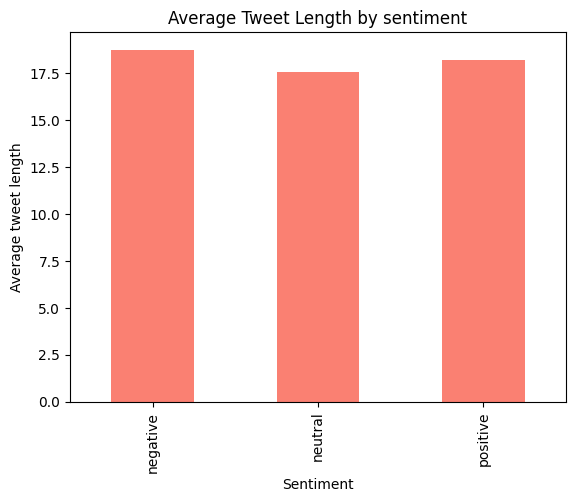

In [18]:
#Class Distribution by tweet length
df.groupby('sentiment')['tweet_length'].mean().plot(kind='bar', color= 'salmon')
plt.title('Average Tweet Length by sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average tweet length')
plt.show()


The bar chart indicates that the average tweet length for all three sentiment categories (positive, negative, and neutral) is almost equal, ranging between 17 to 18 words, suggesting that tweet length is consistent across different sentiments.

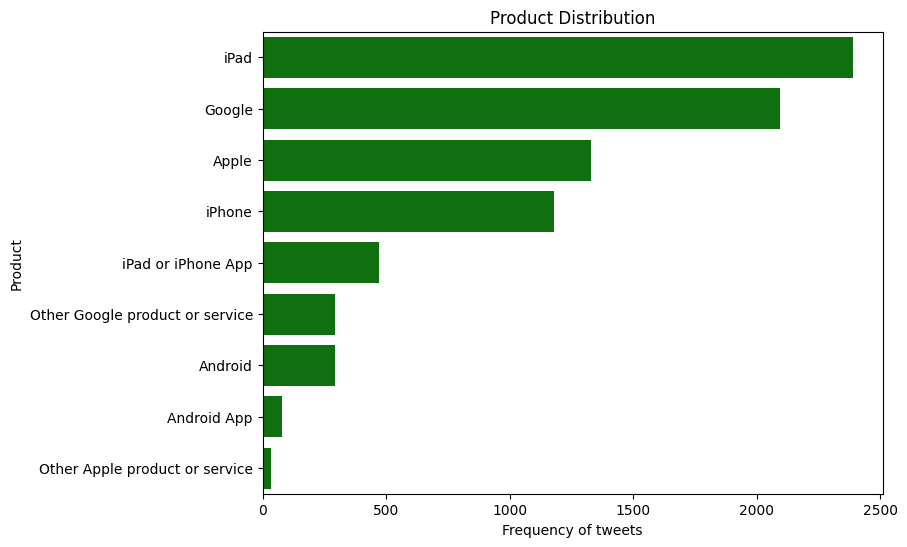

,count
product,
iPad,2390
Google,2093
Apple,1328
iPhone,1178
iPad or iPhone App,469
Other Google product or service,292
Android,291
Android App,80
Other Apple product or service,35


In [19]:
#Distribution of products
product_counts= df['product'].value_counts()

plt.figure(figsize= (8, 6))
labels= product_counts.index
sns.barplot(x= product_counts, y= labels, color= 'green')
plt.title('Product Distribution')
plt.xlabel('Frequency of tweets')
plt.ylabel('Product')
plt.show()

product_counts

The distribution plot of product distribution shows that iPad is the most mentioned product among the tweets, followed by Google and Apple, which proves these brands are on the hotlist and much discussed, whereas the rest of the products like Android and Apple services have been talked about far less.

<Figure size 800x600 with 0 Axes>

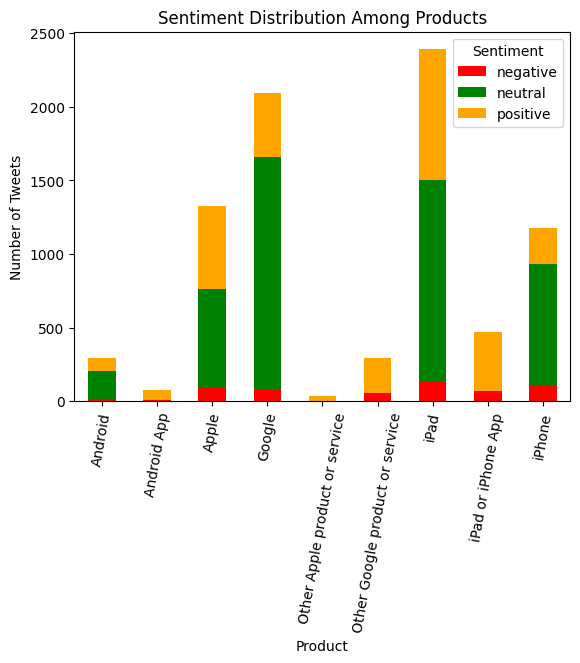

In [20]:
#Sentiment distribution for each product
product_sentiment_counts = df.groupby('product')['sentiment'].value_counts().unstack().fillna(0)

#plot
plt.figure(figsize=(8, 6))

# Plot the sentiment distribution for each product
product_sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'green', 'orange'])

plt.title('Sentiment Distribution Among Products')
plt.xlabel('Product')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=80)
plt.legend(title='Sentiment', labels=product_sentiment_counts.columns)

plt.show()
